<a href="https://colab.research.google.com/github/JovanBosic/Preparation-for-TensorFlow-certificate-2/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problem (seq2seq).

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-99770341-8cd9-9e94-5262-58c8264fd6df)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import of series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-04-23 13:36:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-23 13:36:54 (37.7 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



## Get a text dataset

The dataset we are going to be using is Kaggles introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster). 

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2022-04-23 13:36:58--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.3’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2022-04-23 13:36:58 (97.4 MB/s) - ‘nlp_getting_started.zip.3’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [4]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][6]

'#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Lets visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", '(real disaster)' if target > 0 else '(not real disaster)')
  print(f"Text:\n{text}\n")
  print('---\n')

Target: 1 (real disaster)
Text:
Man crushed to death by own car http://t.co/CrPO9DkW9v

---

Target: 1 (real disaster)
Text:
#hiphop #news #indie Apollo Brown ÛÒ ÛÏDetonateÛ Ft. M.O.P. - &lt;a href='http://t.co/WnowfVCbMs... http://t.co/JxWOjxqndC

---

Target: 0 (not real disaster)
Text:
å¤} New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/UooZXauS26 http://t.co/6MGBizjfgd RT enÛ_

---

Target: 0 (not real disaster)
Text:
My hands are cold but my feet are warm. That's where I keep my lava

---

Target: 0 (not real disaster)
Text:
Not because i want to cheat or anything. Just feels good to vent to my twitter without a txt being screamed at lol

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
len(train_df_shuffled)

7613

In [15]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you will have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [16]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV> #out of vocabulary))
                                    standardize="lower_and_strip_punctuation",
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words
                                    output_mode='int',
                                    output_sequence_length=None, # how long do you want your sequences to be - all has to be the same lenght (if shorter padding with 0)
                                    #pad_to_max_tokens=True
                                    )


In [18]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [19]:
len(train_sentences[0].split())

7

In [20]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [21]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequence will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [22]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [23]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [24]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
# Choose a random sentence fromm the trainng dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original text:
 30 seconds for my bitches to evacuate ??????      

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 718, 1599,   10,   13, 3149,    5,  279,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [26]:
# Get the unique words in the vocabulary 
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using Embedding Layer

To make our embedding, we are going to use TensorFlows embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [27]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             input_length=max_length # how long is each input
                             )
embedding

In [28]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence}\
        \n\n Embedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 What a wonderful day!        

 Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01294448,  0.0486491 , -0.03296772, ..., -0.01964741,
          0.00156547, -0.03878902],
        [-0.04168347,  0.00222139, -0.01163989, ..., -0.00329759,
         -0.00319989,  0.01579768],
        [ 0.00134457, -0.04385923, -0.04645237, ...,  0.00672679,
          0.03095425, -0.00270183],
        ...,
        [-0.01655113, -0.0091175 ,  0.01917163, ..., -0.00840566,
         -0.04674613,  0.0216441 ],
        [-0.01655113, -0.0091175 ,  0.01917163, ..., -0.00840566,
         -0.04674613,  0.0216441 ],
        [-0.01655113, -0.0091175 ,  0.01917163, ..., -0.00840566,
         -0.04674613,  0.0216441 ]]], dtype=float32)>

In [29]:
# Check out a single tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01294448,  0.0486491 , -0.03296772,  0.04762319, -0.02535961,
        -0.03988303,  0.02274886, -0.02366614,  0.04106161, -0.02625538,
         0.00073818, -0.00403267,  0.03971216,  0.02830039, -0.01525667,
        -0.03312111,  0.03709661, -0.02623073,  0.04532174, -0.0063431 ,
        -0.02324688,  0.01987122, -0.02960122, -0.03081722,  0.04890877,
         0.04422648,  0.04056622,  0.02044233,  0.04888347, -0.04021665,
        -0.04624746,  0.03892289, -0.04041751, -0.00923033, -0.04602931,
        -0.01844282,  0.01809219, -0.02420676,  0.03158185, -0.00118767,
         0.03164799,  0.03827712,  0.01730936, -0.00073069,  0.0402577 ,
        -0.04190748, -0.02960681, -0.01116937, -0.04348564,  0.0453835 ,
         0.04576385, -0.01655095,  0.00173674, -0.04051227,  0.00236036,
         0.00222348, -0.00591551,  0.01537523,  0.01159181, -0.03491701,
         0.02608511, -0.01386566,  0.0122158 ,  0.04135747,  0.03225659,
  

## Modelling a text dataset (running a series of experiments)

Now we have a got way to turn our text seqences into numbers, its time to start building a series of modelling experiments.

We will start with a baseline and move on from there.

* Model 0: Naive Bayas (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Covolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, its important too create a baseline model so you have got a benchmark for future experiments to build upon.

To create our baseline, we will use Sklearns Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note**: Its common practice to use non-DL algorithms as a baseline because of their speen and then later using DL to see if you can improve upon them. 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # convert workds to numbers using tfidf
                    ('clf', MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achives an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achives an accuracy of: 79.27%


In [32]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [33]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our models predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function...

Lets create one to compare our models predictions with the truth labels using thye following metrics:

* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many diferent evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [34]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculates model accuracy, precision, recall and f1 score opf a binary classification model.
  '''
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [35]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [36]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [37]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers 
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [38]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [39]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220423-133701
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.6123 - accuracy: 0.6945 - val_loss: 0.5358 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4425 - accuracy: 0.8199 - val_loss: 0.4700 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3475 - accuracy: 0.8593 - val_loss: 0.4585 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2857 - accuracy: 0.8895 - val_loss: 0.4621 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2374 - accuracy: 0.9134 - val_loss: 0.4837 - val_accuracy: 0.7822


In [41]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.4837 - accuracy: 0.7822


[0.4836944043636322, 0.7821522355079651]

In [42]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [43]:
# Look at the single prediction
model_1_pred_probs[0]

array([0.33044648], dtype=float32)

In [44]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.33044648],
       [0.6994196 ],
       [0.9969452 ],
       [0.15693228],
       [0.09123955],
       [0.9362017 ],
       [0.8981181 ],
       [0.9936791 ],
       [0.9596863 ],
       [0.32845655]], dtype=float32)

In [45]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [46]:
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [47]:
# Calculate mour model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'f1': 0.7789371307867892,
 'precision': 0.7872762884426117,
 'recall': 0.7821522309711286}

In [48]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [49]:
# Looks like our baseline model is out performing our first deep learning model...
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

 ## Visualizing learned embeddings

In [50]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [51]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [52]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim or our embedding layer)

(10000, 128)


In [53]:
embed_weights

array([[-0.02893266, -0.02023108,  0.00903241, ...,  0.00066889,
        -0.03495499,  0.01939992],
       [ 0.00933857, -0.02949044,  0.03119469, ...,  0.05148831,
         0.0359003 ,  0.0394261 ],
       [-0.0468258 , -0.06733166, -0.01474233, ...,  0.01178594,
         0.02962807, -0.06311416],
       ...,
       [ 0.03987991,  0.04437847, -0.00547218, ...,  0.0064155 ,
         0.04297801, -0.02970458],
       [-0.06902909, -0.00900714, -0.02801603, ...,  0.01557922,
         0.0522357 , -0.05674634],
       [-0.06976631, -0.05507536, -0.05934558, ...,  0.05659263,
         0.08404254, -0.05360014]], dtype=float32)

Now we have gt the embedding matrix our model has learned to represent our tokens, lets see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incrediable quide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [54]:
# Create embedding files (we got this from TensorFlows word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [55]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:

  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the files above we can visualize them using https://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

> 📚**Resources**: If you would like to know more about embeddings, I'd encourage you to check out:
* Jay Alammars visualized word2vec post: https://jalammar.github.io/
* TensorFlows Word Embeddings guide: https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input. 

> 📚 **Resources**: If you want an overview of the internals of a recurrent neural network, see the followint:
- MIT's sequence modelling lecture : https://www.youtube.com/watch?v=QvkQ1B3FBqA&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3
- Chirs OLah's intro to LSTMs : https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of RNN's : http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/Dense) -> Output (label probability)
```

In [56]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you are stacking RNN cells together, you need to set return_sequencet=True
# print(x.shape) 
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [57]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [58]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [59]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220423-133729
Epoch 1/5
215/215 [==============================] - 9s 16ms/step - loss: 0.2233 - accuracy: 0.9206 - val_loss: 0.5805 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1590 - accuracy: 0.9416 - val_loss: 0.6209 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1298 - accuracy: 0.9521 - val_loss: 0.6669 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1030 - accuracy: 0.9623 - val_loss: 0.7613 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0839 - accuracy: 0.9672 - val_loss: 0.8038 - val_accuracy: 0.7717


In [60]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.03405535],
       [0.67757326],
       [0.9997278 ],
       [0.0947023 ],
       [0.00125973],
       [0.9986547 ],
       [0.79452294],
       [0.999897  ],
       [0.9997851 ],
       [0.48308244]], dtype=float32)

In [61]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [62]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.16535433070865,
 'f1': 0.7690403853056418,
 'precision': 0.7744533306963004,
 'recall': 0.7716535433070866}

In [63]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has the similar features to an LSTM cell but has less paramenters.

In [64]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [65]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [66]:
# Compile the momdel
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [67]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220423-133756
Epoch 1/5
215/215 [==============================] - 7s 20ms/step - loss: 0.1585 - accuracy: 0.9378 - val_loss: 0.6716 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0834 - accuracy: 0.9699 - val_loss: 0.8673 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0709 - accuracy: 0.9740 - val_loss: 0.9268 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0604 - accuracy: 0.9750 - val_loss: 1.1688 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0517 - accuracy: 0.9775 - val_loss: 1.3379 - val_accuracy: 0.7782


In [68]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[5.5283267e-04],
       [7.4988365e-01],
       [9.9989641e-01],
       [2.3202561e-02],
       [9.9331781e-05],
       [9.9989629e-01],
       [9.7872776e-01],
       [9.9997461e-01],
       [9.9993193e-01],
       [9.1617239e-01]], dtype=float32)

In [69]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7772416104347588,
 'precision': 0.7782520175632252,
 'recall': 0.7782152230971129}

### Model 4: Bidirectional RNN

Normal RNNs go from left to right (just like you would read an English sentence) however, a biderectional RNN goes from right to left as well as left to right.

In [71]:
# Build a biderectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_biderectional')

In [72]:
# Get a summary
model_4.summary()

Model: "model_4_biderectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [73]:
# Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [74]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220423-133821
Epoch 1/5
215/215 [==============================] - 11s 27ms/step - loss: 0.1053 - accuracy: 0.9677 - val_loss: 0.9146 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0557 - accuracy: 0.9774 - val_loss: 1.1570 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0479 - accuracy: 0.9788 - val_loss: 1.1926 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0452 - accuracy: 0.9793 - val_loss: 1.2010 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0467 - accuracy: 0.9769 - val_loss: 1.3186 - val_accuracy: 0.7769


In [75]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]


array([[2.6886985e-03],
       [7.0868564e-01],
       [9.9998569e-01],
       [1.4022750e-01],
       [3.1745192e-05],
       [9.9944180e-01],
       [9.0310907e-01],
       [9.9999213e-01],
       [9.9997747e-01],
       [9.7802359e-01]], dtype=float32)

In [76]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.69028871391076,
 'f1': 0.774064384984916,
 'precision': 0.7805885493126917,
 'recall': 0.7769028871391076}

In [78]:
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7772416104347588,
 'precision': 0.7782520175632252,
 'recall': 0.7782152230971129}

## Convolutional Neural Networks for Text (and other types of sequences)

We have used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we have used Conv2D for our image data but now we are going to use Conv1D.

The typical structure of a Conv1D model sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between 'same' and 'valid' padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [79]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['thiss is a test sentence'])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also reffered to as an ngram of 5 (meaning is looks at 5 words at a time)
                        strides=1,
                        activation='relu',
                        padding='valid') # 'valid' - the output is smaller than the input shape, 'same' - the output is same shape as the input

conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [80]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00813067,  0.00632175,  0.04905841, ...,  0.03358337,
          0.03177381,  0.0548983 ],
        [-0.01174514, -0.00140668, -0.05382437, ..., -0.00426945,
         -0.02687226, -0.05170504],
        [-0.06895682, -0.02031585, -0.02771345, ...,  0.00027138,
          0.02397987,  0.00307366],
        ...,
        [-0.02513732, -0.02204142,  0.01149442, ...,  0.01704954,
         -0.00537444,  0.00170473],
        [-0.02513732, -0.02204142,  0.01149442, ...,  0.01704954,
         -0.00537444,  0.00170473],
        [-0.02513732, -0.02204142,  0.01149442, ...,  0.01704954,
         -0.00537444,  0.00170473]]], dtype=float32)>

In [81]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.03905762, 0.021907  , 0.        ,
         0.        , 0.04269503, 0.00231411, 0.        , 0.00684608,
         0.        , 0.        , 0.        , 0.00251626, 0.        ,
         0.03906954, 0.        , 0.        , 0.        , 0.04216114,
         0.00831589, 0.01020222, 0.        , 0.00854479, 0.        ,
         0.        , 0.        , 0.00918077, 0.00166217, 0.        ,
         0.01061412, 0.        ],
        [0.        , 0.00322307, 0.        , 0.        , 0.        ,
         0.        , 0.01962639, 0.0184259 , 0.04920796, 0.07883416,
         0.        , 0.01931438, 0.12074491, 0.        , 0.01327101,
         0.        , 0.02372894, 0.        , 0.02105113, 0.        ,
         0.        , 0.01446709, 0.02243964, 0.03379092, 0.        ,
         0.06517737, 0.        , 0.        , 0.04530308, 0.09057173,
         0.        , 0.02151079],
        [0.        , 0.        , 0.        , 0.0600

In [82]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.04604571, 0.00840172, 0.03905762, 0.06001205, 0.00680826,
        0.        , 0.04269503, 0.03744067, 0.04920796, 0.07883416,
        0.03488971, 0.01931438, 0.12074491, 0.05748457, 0.03206744,
        0.06080877, 0.03528805, 0.00775744, 0.06694093, 0.04216114,
        0.04453079, 0.01446709, 0.03141964, 0.03379092, 0.04773489,
        0.06517737, 0.0223602 , 0.02865879, 0.04530308, 0.09057173,
        0.05312218, 0.02151079]], dtype=float32)>

In [83]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [84]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_5_Conv1D')])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20220423-133909
Epoch 1/5
215/215 [==============================] - 5s 16ms/step - loss: 0.1258 - accuracy: 0.9578 - val_loss: 0.9129 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0745 - accuracy: 0.9720 - val_loss: 1.1021 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0624 - accuracy: 0.9764 - val_loss: 1.1227 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0563 - accuracy: 0.9772 - val_loss: 1.2224 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0505 - accuracy: 0.9785 - val_loss: 1.2522 - val_accuracy: 0.7638


In [85]:
# Make some predictios with our COnv1D model
model_5_pred_probs = model_5.predict(val_sentences)

In [86]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [87]:
# Evaluate model 5 predictions
model_5_results = calculate_results(val_labels,
                                    model_5_preds)
model_5_results

{'accuracy': 76.37795275590551,
 'f1': 0.761768588939328,
 'precision': 0.7649838845988884,
 'recall': 0.7637795275590551}

### Model 6: TensoFlow Hub Pretrained Sentence Encoder

Now we have built a few of our own models, lets try and use transfer learning for NLP, specifically using TensorFlow Hubs Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [88]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       'When you call the universal sentence encoder on a sentence, it turns it into numbers'])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729   0.00639324 -0.01819523
  0.00030817  0.09105891  0.05874644 -0.03180627  0.01512476 -0.05162928
  0.00991369 -0.06865346 -0.04209306  0.0267898   0.03011008  0.00321069
 -0.00337969 -0.04787359  0.02266718 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871508  0.04947682 -0.00633971 -0.08960191  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361786 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [89]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157024,  0.0248591 ,  0.0287805 , ..., -0.00186124,
         0.02315823, -0.01485021],
       [ 0.03596687, -0.08579467, -0.01152741, ..., -0.03414335,
         0.02816026, -0.00878944]], dtype=float32)>

In [90]:
sample_sentence

"There's a flood in my street!"

In [91]:
embed_samples.shape

TensorShape([2, 512])

In [92]:
# Create  a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],# variable length
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [93]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [94]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220423-133956
Epoch 1/5
215/215 [==============================] - 15s 44ms/step - loss: 0.5058 - accuracy: 0.7797 - val_loss: 0.4462 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 8s 39ms/step - loss: 0.4135 - accuracy: 0.8156 - val_loss: 0.4397 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.4010 - accuracy: 0.8221 - val_loss: 0.4311 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 9s 41ms/step - loss: 0.3915 - accuracy: 0.8257 - val_loss: 0.4281 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.3847 - accuracy: 0.8285 - val_loss: 0.4274 - val_accuracy: 0.8110


In [95]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.17090991],
       [0.7497554 ],
       [0.99029034],
       [0.20568028],
       [0.6947444 ],
       [0.7000259 ],
       [0.9846907 ],
       [0.9769713 ],
       [0.93418276],
       [0.08974504]], dtype=float32)

In [96]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))


In [97]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels,
                                    model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.809201931950287,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441}

In [98]:
 baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 7: TF Hub Pretrained USE with 10% of training data

Transfer learning really helps when you dont have a large dataset.

To see how our model performs on a smaller dataset, lets replicate `model_6` except we will train it on 10% of the data.

In [99]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperformns model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

> 🔑 **Note**: Be *very* careful when creating training/val/test splits that you dont leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% data) trust your gut and go back through to find where the error may lie.

In [100]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [101]:
train_10_percent[:10]

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1
6358,Investigators rule catastrophic structural fai...,1
59,How the West was burned: Thousands of wildfire...,1
7018,Map: Typhoon Soudelor's predicted path as it a...,1
455,Ûª93 blasts accused Yeda Yakub dies in Karach...,1
727,My ears are bleeding https://t.co/k5KnNwugwT,0


In [102]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [103]:
# Check the number of target in our subset of data
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [104]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you have created you can use `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [105]:
# Lets build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will be same as model_6)
model_7.summary()


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [106]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_10_percent')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20220423-134133
Epoch 1/5
22/22 [==============================] - 9s 134ms/step - loss: 0.6683 - accuracy: 0.7066 - val_loss: 0.6475 - val_accuracy: 0.7795
Epoch 2/5
22/22 [==============================] - 1s 61ms/step - loss: 0.5999 - accuracy: 0.8000 - val_loss: 0.5933 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 1s 61ms/step - loss: 0.5249 - accuracy: 0.8219 - val_loss: 0.5388 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 2s 93ms/step - loss: 0.4621 - accuracy: 0.8219 - val_loss: 0.5063 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 2s 95ms/step - loss: 0.4232 - accuracy: 0.8277 - val_loss: 0.4908 - val_accuracy: 0.7782


In [107]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.23361447],
       [0.61619705],
       [0.90557545],
       [0.35290942],
       [0.57464254],
       [0.7009317 ],
       [0.86943805],
       [0.8104287 ],
       [0.8354455 ],
       [0.16955453]], dtype=float32)

In [108]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [109]:
# Evaluate model 7 prediciotns
model_7_results = calculate_results(val_labels,
                                     model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'f1': 0.7773336839908915,
 'precision': 0.7781511319914536,
 'recall': 0.7782152230971129}

In [110]:
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.809201931950287,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441}

## Comparing the performance of each of our models

In [114]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_sample_danse': model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_sample_danse,78.215223,0.787276,0.782152,0.778937
2_lstm,77.165354,0.774453,0.771654,0.769040
3_gru,77.821522,0.778252,0.778215,0.777242
4_bidirectional,77.690289,0.780589,0.776903,0.774064
5_conv1d,76.377953,0.764984,0.763780,0.761769
6_tf_hub_use_encoder,81.102362,0.814034,0.811024,0.809202
7_tf_hub_use_encoder_10_percent,77.821522,0.778151,0.778215,0.777334


In [115]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_sample_danse,0.782152,0.787276,0.782152,0.778937
2_lstm,0.771654,0.774453,0.771654,0.769040
3_gru,0.778215,0.778252,0.778215,0.777242
4_bidirectional,0.776903,0.780589,0.776903,0.774064
5_conv1d,0.763780,0.764984,0.763780,0.761769
6_tf_hub_use_encoder,0.811024,0.814034,0.811024,0.809202
7_tf_hub_use_encoder_10_percent,0.778215,0.778151,0.778215,0.777334


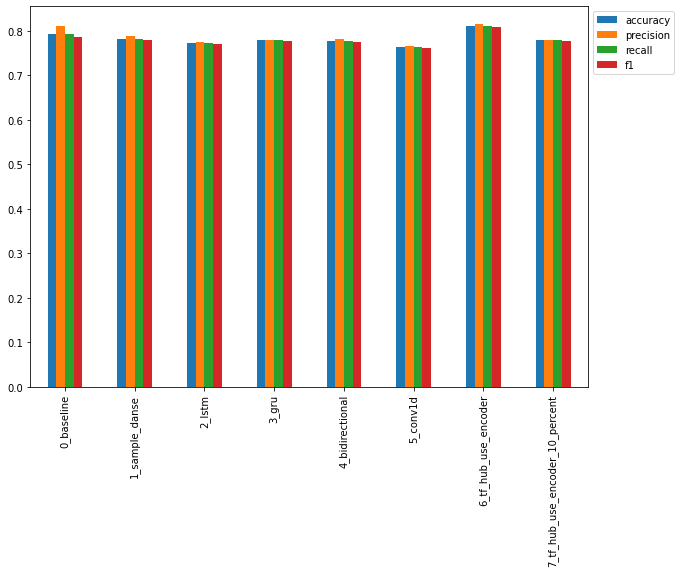

In [118]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

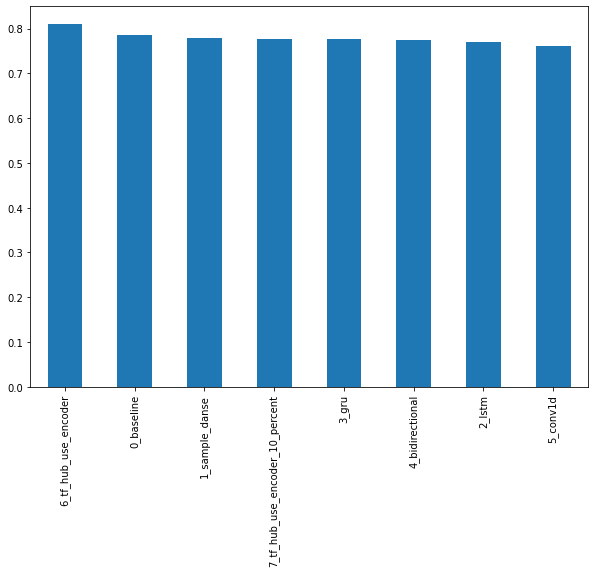

In [119]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different typres of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot # exit the uploader once uploading is finished 

Now I have ran the cell above, my modelling experiments are visable on TensorBoard dev:  https://tensorboard.dev/experiment/jIYSJueARNuLDCnzxE1v1A/

> 📚 **Resource**: TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

## Saving and loading a treined model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [121]:
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.809201931950287,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441}

In [122]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [123]:
import tensorflow_hub as hub

# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [124]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 35ms/step - loss: 0.4274 - accuracy: 0.8110


[0.42740559577941895, 0.8110235929489136]

In [126]:
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.809201931950287,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441}

Now lets save to `SavedModel` format... (see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)



In [127]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save('model_6_SavedModel_format')

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [128]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [131]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 19ms/step - loss: 0.4274 - accuracy: 0.8110


[0.42740559577941895, 0.8110235929489136]

## Finding the most wrong examples

* If our base model still isnt perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)
 
For example if a sample should have a label of 0 but our model predicts a prediction probability 0.999 (really close to 1) and vice versa.

In [132]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-04-23 15:01:13--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  50.2MB/s    in 18s     

2022-04-23 15:01:31 (51.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [133]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 33ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [134]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [138]:
# Create DataFrame with validation sentencecs, validation labes and best performing model prediction labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'predprobs': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head() 

,text,target,pred,predprobs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [141]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('predprobs', ascending=False)
most_wrong.head() # These are false positives

,text,target,pred,predprobs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


Lets remind ourselves of the target labels...
* 0 = not disaster
* 1 = disaster

In [142]:
most_wrong.tail() # These are false negatives

,text,target,pred,predprobs
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [144]:
# Check the false positives (model predicted 1 when should have been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, predprobs = row
  print(f"Target: {target}, Pred: {pred}, Prob: {predprobs}")
  print(f"Text: \n {text} \n")
  print("------\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text: 
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying 

------

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text: 
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J 

------

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text: 
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME. 

------

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text: 
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0 

------

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text: 
 @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans. 

------

Target: 0, Pred: 1.0, Prob: 0.8148158192634583
Text: 
 @SonofLiberty357 all illuminated by the brightly burning building

In [146]:
# Check the false negatives (model predicted 0 when should have been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, predprobs = row
  print(f"Target: {target}, Pred: {pred}, Prob: {predprobs}")
  print(f"Text: \n {text} \n")
  print("------\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text: 
 @DavidVonderhaar At least you were sincere ?? 

------

Target: 1, Pred: 0.0, Prob: 0.055075809359550476
Text: 
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu 

------

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text: 
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets 

------

Target: 1, Pred: 0.0, Prob: 0.05459696426987648
Text: 
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy 

------

Target: 1, Pred: 0.0, Prob: 0.04963728412985802
Text: 
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you. 

------

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text: 
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren 

------



## Making predictions on the test dataset

In [149]:
# Making predictions on the test dataset and visualizing them
test_sentencecs = test_df['text'].to_list()
test_sentencecs[:5]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan']

In [155]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 1, Prob: 0.9722896814346313
Text:
As California fires rage the Forest Service sounds the alarm about sharply rising wildfire costs http://t.co/ht8FyiMJlR

-----

Pred: 1, Prob: 0.9429036378860474
Text:
Flood: Two people dead 60 houses destroyed in Kaduna http://t.co/8H2SP6Ze3o

-----

Pred: 1, Prob: 0.9464319944381714
Text:
What if the fire up in the Catalinas gets worse and we have to evacuate the area. Aka no school tomorrow

-----

Pred: 1, Prob: 0.8925358653068542
Text:
Pickup Truck Fire On Driscoll Bridge Snags Garden State Parkway #NewYork http://t.co/Q5YU2tZGte

-----

Pred: 0, Prob: 0.2033219039440155
Text:
Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/ma9LLiKcjk

-----

Pred: 0, Prob: 0.42981162667274475
Text:
Gutted. 6 weeks to go. Suspected fracture to my left ankle. Trauma clinic to see Specialist tomorrow #gnr @sageuk http://t.co/wa3sIUtoI0

-----

Pred: 1, Prob: 0.8772149085998535
Text:


## The speed/score tradeoff

In [156]:
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.809201931950287,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441}

In [157]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [158]:
# Lets make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  '''
  Times how long a model takes to make predictions on samples
  '''
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predicitons took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [159]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(1.2336844400015252, 0.0016190084514455712)

In [160]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.047670086001744494, 6.255916798129198e-05)

In [161]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(val_labels,
                                               model_6_pretrained_preds)

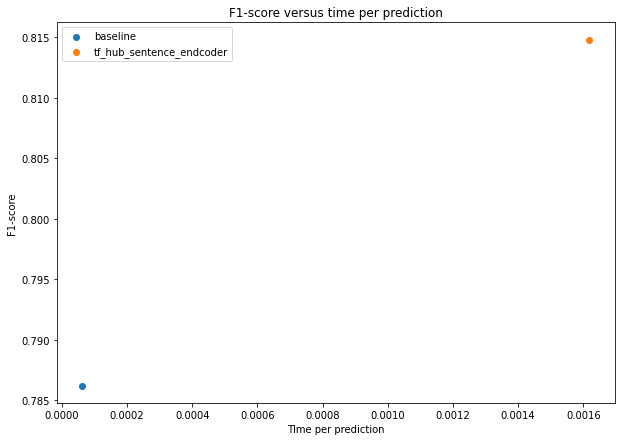

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_endcoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('TIme per prediction')
plt.ylabel('F1-score');